In [130]:
from types import SimpleNamespace

import matplotlib.animation as anm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

COLUMN = SimpleNamespace(**{
    'PLAY_TYPE': 'specialTeamsPlayType',
    'POSITION': 'position',
    'PLAY_EVENT': 'event',
    'GAME_ID': 'gameId',
    'PLAY_ID': 'playId',
    'GUNNERS': 'gunners',
    'GUNNER_LIST': 'gunnerList',
    'HOME_TEAM': 'homeTeamAbbr',
    'VISITOR_TEAM': 'visitorTeamAbbr',
    'IS_GUNNER': 'isGunner',
    'JERSEY_NUMBER': 'jerseyNumber',
    'TEAM': 'team',
    'POSSESSION_TEAM': 'possessionTeam',
    'TIME': 'time',
    'NFL_ID': 'nflId',
    'PLAYER_TEAM_ID': 'playerTeamId',
})

POSITION = SimpleNamespace(**{
    'KICKER': 'K',
    'PUNTER': 'P',
    'LONG_SNAPPER': 'LS',
})

PLAY_TYPE = SimpleNamespace(**{
    'FIELD_GOAL': 'Field Goal',
    'PUNT': 'Punt',
})

PLAY_EVENT = SimpleNamespace(**{
    'SNAP': 'ball_snapped',
    'FG_ATTEMPT': 'field_goal_attempt',
    'PUNT': 'punt',
})

PLAY_RESULT = SimpleNamespace(**{
    'BLOCKED': 'Blocked Kick Attempt',
    'DOWNED': 'Downed',
    'KICK_GOOD': 'Kick Attempt Good',
    'KICK_NO_GOOD': 'Kick Attempt No Good',
})


In [87]:
games_df = pd.read_csv('input/games.csv')
players_df = pd.read_csv('input/players.csv')
plays_df = pd.read_csv('input/plays.csv')
pff_scouting_df = pd.read_csv('input/PFFScoutingData.csv')
tracking_2018_df = pd.read_csv('input/tracking2018.csv')
game_plays_df = pd.merge(games_df, plays_df, left_on=COLUMN.GAME_ID, right_on=COLUMN.GAME_ID)

In [141]:
tracking_2018_df[COLUMN.TIME] = pd.to_datetime(tracking_2018_df[COLUMN.TIME])
tracking_2018_df[COLUMN.JERSEY_NUMBER] = tracking_2018_df[COLUMN.JERSEY_NUMBER].astype('Int64')

In [142]:
punt_tracking_2018_df = pd.merge(
    pff_scouting_df,
    tracking_2018_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)
punt_plays_df = game_plays_df[game_plays_df[COLUMN.PLAY_TYPE] == PLAY_TYPE.PUNT]
punt_tracking_2018_df = pd.merge(
    punt_tracking_2018_df,
    punt_plays_df,
    left_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
    right_on=[COLUMN.GAME_ID, COLUMN.PLAY_ID],
)

In [143]:
conditions = [
    (punt_tracking_2018_df[COLUMN.TEAM].isna()),
    (punt_tracking_2018_df[COLUMN.TEAM] == 'home'),
    (punt_tracking_2018_df[COLUMN.TEAM] == 'away'),
]

values = [
    np.NaN,
    punt_tracking_2018_df[COLUMN.HOME_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
    punt_tracking_2018_df[COLUMN.VISITOR_TEAM] + ' ' + punt_tracking_2018_df[COLUMN.JERSEY_NUMBER].astype(str),
]

punt_tracking_2018_df[COLUMN.PLAYER_TEAM_ID] = np.select(conditions, values)

def splitGunners(value):
    if value is None:
        return []
    gunners = str(value).split(';')
    return [gunner.strip() for gunner in gunners]

punt_tracking_2018_df[COLUMN.GUNNER_LIST] = punt_tracking_2018_df[COLUMN.GUNNERS].apply(splitGunners)

punt_tracking_2018_df[COLUMN.IS_GUNNER] = punt_tracking_2018_df.apply(
    lambda x: str(x[COLUMN.PLAYER_TEAM_ID]) in x[COLUMN.GUNNER_LIST],
    axis=1,
)

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_65353/2688148759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_punt_df['frame'] = first_punt_df[COLUMN.TIME].rank(ascending=True, method='dense')
/Users/jonathanfearer/.local/share/virtualenvs/kaggle-nfl-data-bowl-2022-1iBfW-I5/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


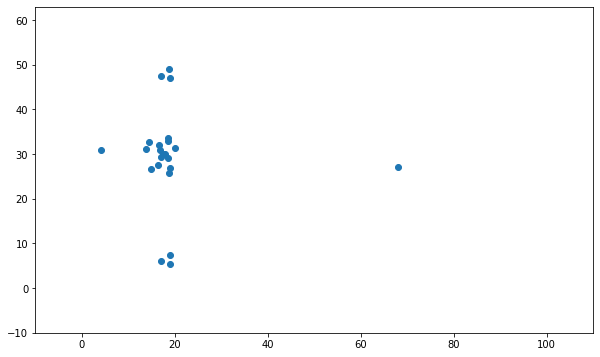

In [151]:
first_punt_df = punt_tracking_2018_df[
    (punt_tracking_2018_df[COLUMN.GAME_ID] == 2018090600) &
    (punt_tracking_2018_df[COLUMN.PLAY_ID] == 366)
]
first_punt_df['frame'] = first_punt_df[COLUMN.TIME].rank(ascending=True, method='dense')
conditions = [
    first_punt_df[COLUMN.IS_GUNNER],
    first_punt_df[COLUMN.TEAM] == 'home',
    first_punt_df[COLUMN.TEAM] == 'away',
]
values = [
    'orange',
    'green',
    'blue',
]
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(-10, 110), ylim=(-10, 63))
# c = np.select(conditions, values)
x = first_punt_df[first_punt_df['frame'] == 1]['x']
y = first_punt_df[first_punt_df['frame'] == 1]['y']
scatter = ax.scatter(x, y)

def animate(i):
    print(i)
    x = first_punt_df[first_punt_df['frame'] == i]['x']
    y = first_punt_df[first_punt_df['frame'] == i]['y']
    data = np.hstack((x, y))
    scatter.set_offsets(data)

animation = anm.FuncAnimation(fig, animate, interval=100, frames=100)


In [149]:
first_punt_df['frame'] = first_punt_df[COLUMN.TIME].rank(ascending=True, method='dense')
first_punt_df[[COLUMN.TIME, COLUMN.NFL_ID, 'frame']].sort_values('frame')

/var/folders/52/hkjzjmqn5_q8s9nzy_3_w75c0000gn/T/ipykernel_65353/3247912361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_punt_df['frame'] = first_punt_df[COLUMN.TIME].rank(ascending=True, method='dense')


,time,nflId,frame
0,2018-09-07 01:18:14.000,32361.0,1.0
2304,2018-09-07 01:18:14.000,46194.0,1.0
640,2018-09-07 01:18:14.000,42450.0,1.0
2048,2018-09-07 01:18:14.000,45599.0,1.0
2688,2018-09-07 01:18:14.000,46269.0,1.0
896,2018-09-07 01:18:14.000,42942.0,1.0
1920,2018-09-07 01:18:14.000,45070.0,1.0
1024,2018-09-07 01:18:14.000,43442.0,1.0
1152,2018-09-07 01:18:14.000,43497.0,1.0
1792,2018-09-07 01:18:14.000,44997.0,1.0
